# W207 Final Project - Facial Keypoint Recognition Baseline
#### Alex Carite | Oscar Linares | Greg Rosen | Shehzad Shahbuddin

In [35]:
%matplotlib inline


import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import time
import os.path
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D

np.random.seed(0)
print ("OK")
import tensorflow as tf
print("Tensorflow version", tf.__version__)

OK
Tensorflow version 2.8.0


In [4]:
np.random.rand(1)


array([0.5488135])

In [5]:
#Checking to see if the train/test csv are loaded, if not, unzip from dir
if (os.path.exists('training.csv') == False):
    !unzip training.zip
else:
    print('training data already unzipped')

if (os.path.exists('test.csv') == False):
    !unzip test.zip
else:
    print('test data already unzipped')

training data already unzipped
test data already unzipped


### Load Data 

In [6]:
train = pd.read_csv('training.csv')
test = pd.read_csv('test.csv')
print(train.shape)
print(test.shape)

(7049, 31)
(1783, 2)


# Need to clean up a few NA's in our set


In [8]:
def two_dim(image):
    'takes in an image vector of 9,216 pixels and makes it into a 96x96 shape'
    return np.array(image.split(' '), dtype=int).reshape(96, 96)

def make_array(image):
    return np.array(image.split(' '), dtype=int)


In [9]:
#X = np.array([two_dim(train.Image[i]) for i in range(len(train))])
X = np.array([make_array(train.Image[i]) for i in range(len(train))])
X = X / 255.0
Y = np.array([train.drop('Image', axis = 1).iloc[i] for i in range(len(train))])

#Need to make X_test and Y_test (will we have a Y_test? I think that may be handled in Kaggle)

shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]
train_data, train_labels = X[:5000], Y[:5000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]
dev_data, dev_labels = X[5000:], Y[5000:]
numFeatures = train_data[1].size
numTrainExamples = train_data.shape[0]
numMiniExamples = mini_train_data.shape[0]
numDevExamples = dev_data.shape[0]
# numTestExamples = test_data.shape[0]
print(f'Train examples {numTrainExamples}')
print(f'Train features {numFeatures}')
print(f'mini_Train examples {numMiniExamples}')
print(f'Dev examples {numDevExamples}')
# print(f'Test examples {numTestExamples}')

Train examples 5000
Train features 9216
mini_Train examples 1000
Dev examples 2049


In [39]:
#EDA see how many na's for each column in the training dataset
train.isna().sum()/len(train)*100

left_eye_center_x             0.141864
left_eye_center_y             0.141864
right_eye_center_x            0.184423
right_eye_center_y            0.184423
left_eye_inner_corner_x      67.782664
left_eye_inner_corner_y      67.782664
left_eye_outer_corner_x      67.839410
left_eye_outer_corner_y      67.839410
right_eye_inner_corner_x     67.825223
right_eye_inner_corner_y     67.825223
right_eye_outer_corner_x     67.825223
right_eye_outer_corner_y     67.825223
left_eyebrow_inner_end_x     67.796851
left_eyebrow_inner_end_y     67.796851
left_eyebrow_outer_end_x     68.435239
left_eyebrow_outer_end_y     68.435239
right_eyebrow_inner_end_x    67.796851
right_eyebrow_inner_end_y    67.796851
right_eyebrow_outer_end_x    68.279189
right_eyebrow_outer_end_y    68.279189
nose_tip_x                    0.000000
nose_tip_y                    0.000000
mouth_left_corner_x          67.811037
mouth_left_corner_y          67.811037
mouth_right_corner_x         67.796851
mouth_right_corner_y     

In [11]:
#Drop all NAs to have a clean fully labeled dataset
train_noNA = train.dropna(axis=0, how='any', inplace = False)
train_noNA = train_noNA.reset_index(drop=True)
print(len(train))
print(len(train_noNA))

7049
2140


## Analysis without NA's
We lose 70% of the dataset when removing NAs

In [40]:
#transform dataset into train and dev
X_noNA = np.array([make_array(train_noNA.Image[i]) for i in range(len(train_noNA))])
X_noNA = X_noNA / 255.0
Y_noNA = np.array([train_noNA.drop('Image', axis = 1).iloc[i] for i in range(len(train_noNA))])
noNA_train_data, noNA_train_labels = X_noNA[:1200], Y_noNA[:1200]
noNA_dev_data, noNA_dev_labels = X_noNA[1200:], Y_noNA[1200:]

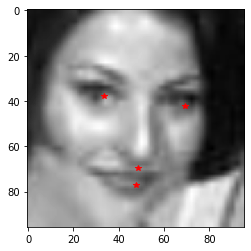

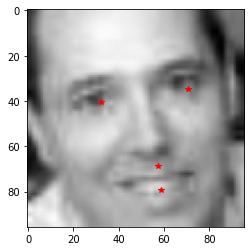

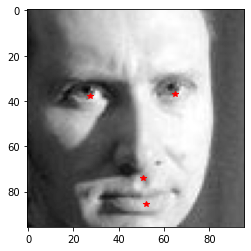

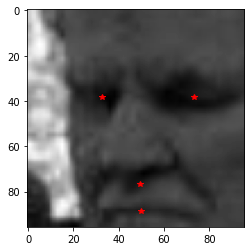

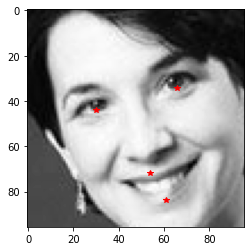

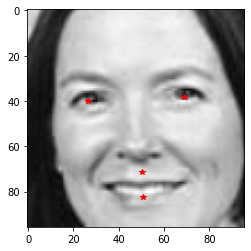

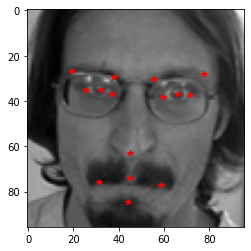

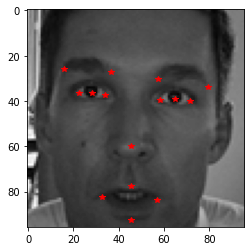

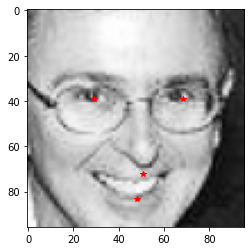

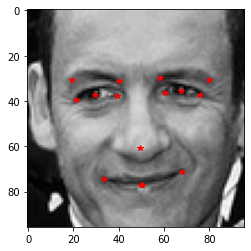

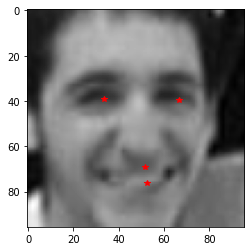

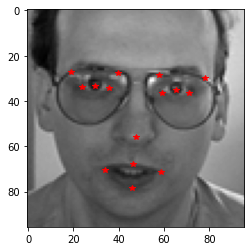

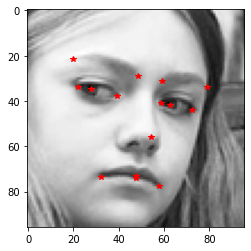

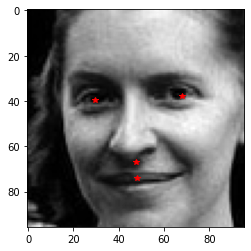

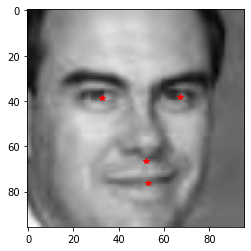

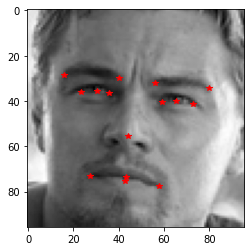

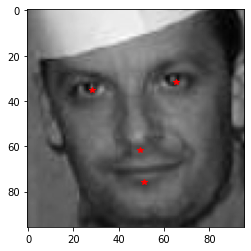

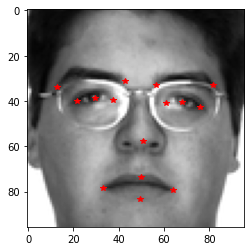

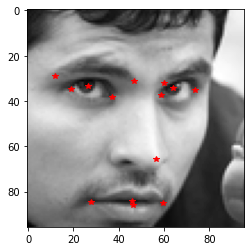

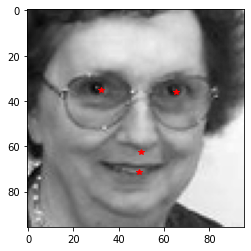

In [41]:
#explore some of the images in the training data
for i in range(20):
    plt.imshow(train_data[i].reshape(96,96),cmap='gray')
    #place a point for each of the pictures on the specified coordinates
    for loc in range(0, len(train_labels[i]),2):
        plt.plot(train_labels[i][loc], train_labels[i][loc+1], '*r')
    plt.show() 
    

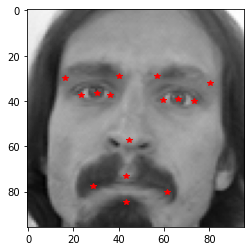

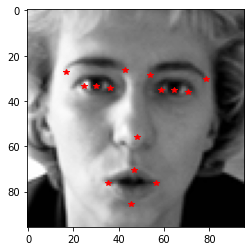

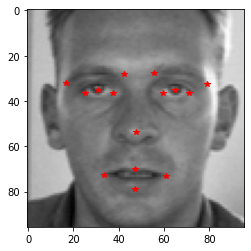

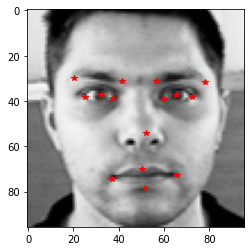

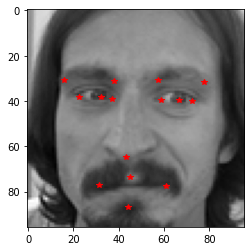

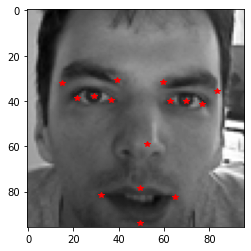

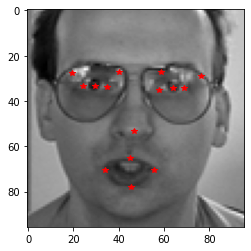

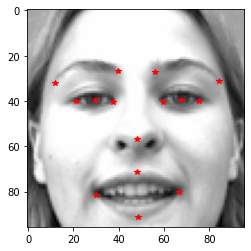

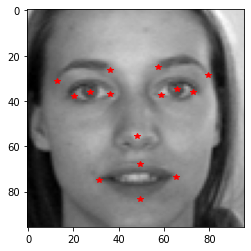

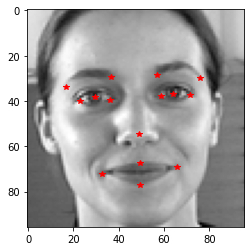

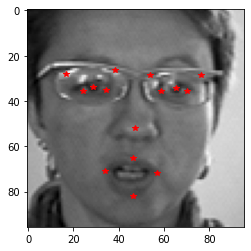

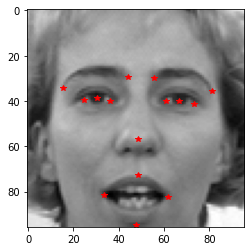

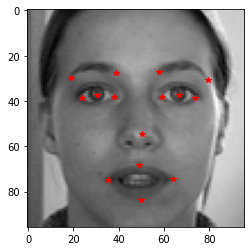

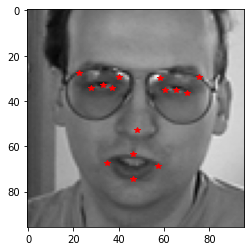

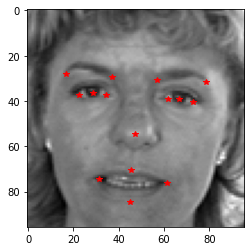

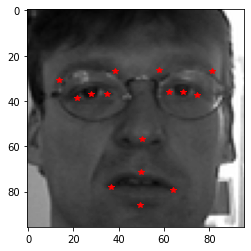

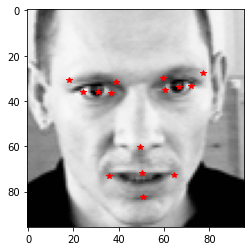

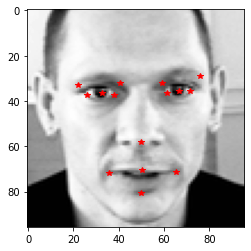

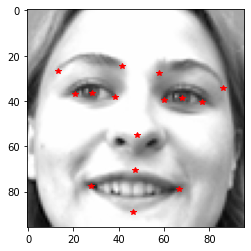

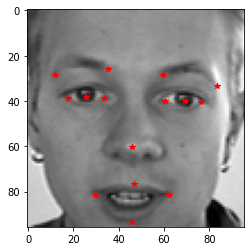

In [42]:
#Same analysis as above but with the noNA dataset - notice the how all the features are marked on the face
#explore some of the images in the training data
for i in range(20):
    plt.imshow(noNA_train_data[i].reshape(96,96),cmap='gray')
    #place a point for each of the pictures on the specified coordinates
    for loc in range(0, len(train_labels[i]),2):
        plt.plot(noNA_train_labels[i][loc], noNA_train_labels[i][loc+1], '*r')
    plt.show() 
    

In [44]:
#List all features
for col in train.columns:
    if col != 'Image':
        print(col)

left_eye_center_x
left_eye_center_y
right_eye_center_x
right_eye_center_y
left_eye_inner_corner_x
left_eye_inner_corner_y
left_eye_outer_corner_x
left_eye_outer_corner_y
right_eye_inner_corner_x
right_eye_inner_corner_y
right_eye_outer_corner_x
right_eye_outer_corner_y
left_eyebrow_inner_end_x
left_eyebrow_inner_end_y
left_eyebrow_outer_end_x
left_eyebrow_outer_end_y
right_eyebrow_inner_end_x
right_eyebrow_inner_end_y
right_eyebrow_outer_end_x
right_eyebrow_outer_end_y
nose_tip_x
nose_tip_y
mouth_left_corner_x
mouth_left_corner_y
mouth_right_corner_x
mouth_right_corner_y
mouth_center_top_lip_x
mouth_center_top_lip_y
mouth_center_bottom_lip_x
mouth_center_bottom_lip_y


array([[<AxesSubplot:title={'center':'left_eye_center_x'}>,
        <AxesSubplot:title={'center':'left_eye_center_y'}>,
        <AxesSubplot:title={'center':'right_eye_center_x'}>,
        <AxesSubplot:title={'center':'right_eye_center_y'}>,
        <AxesSubplot:title={'center':'left_eye_inner_corner_x'}>],
       [<AxesSubplot:title={'center':'left_eye_inner_corner_y'}>,
        <AxesSubplot:title={'center':'left_eye_outer_corner_x'}>,
        <AxesSubplot:title={'center':'left_eye_outer_corner_y'}>,
        <AxesSubplot:title={'center':'right_eye_inner_corner_x'}>,
        <AxesSubplot:title={'center':'right_eye_inner_corner_y'}>],
       [<AxesSubplot:title={'center':'right_eye_outer_corner_x'}>,
        <AxesSubplot:title={'center':'right_eye_outer_corner_y'}>,
        <AxesSubplot:title={'center':'left_eyebrow_inner_end_x'}>,
        <AxesSubplot:title={'center':'left_eyebrow_inner_end_y'}>,
        <AxesSubplot:title={'center':'left_eyebrow_outer_end_x'}>],
       [<AxesSubplot:t

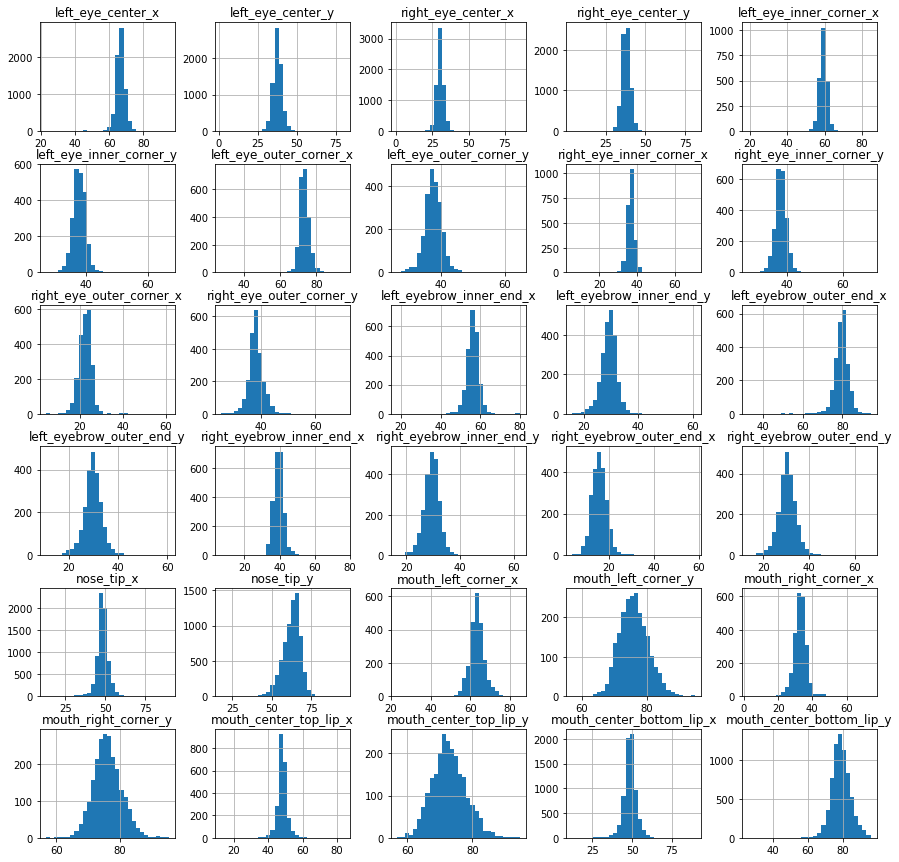

In [45]:
#continue EDA, see distribution of all coordinates in train data except the "Image" column
train.hist(bins = 30, figsize=(15,15))

In [47]:
#create df for noNA data to do the same analysis as above
tempdf = pd.DataFrame(noNA_train_labels)

array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>,
        <AxesSubplot:title={'center':'2'}>,
        <AxesSubplot:title={'center':'3'}>,
        <AxesSubplot:title={'center':'4'}>],
       [<AxesSubplot:title={'center':'5'}>,
        <AxesSubplot:title={'center':'6'}>,
        <AxesSubplot:title={'center':'7'}>,
        <AxesSubplot:title={'center':'8'}>,
        <AxesSubplot:title={'center':'9'}>],
       [<AxesSubplot:title={'center':'10'}>,
        <AxesSubplot:title={'center':'11'}>,
        <AxesSubplot:title={'center':'12'}>,
        <AxesSubplot:title={'center':'13'}>,
        <AxesSubplot:title={'center':'14'}>],
       [<AxesSubplot:title={'center':'15'}>,
        <AxesSubplot:title={'center':'16'}>,
        <AxesSubplot:title={'center':'17'}>,
        <AxesSubplot:title={'center':'18'}>,
        <AxesSubplot:title={'center':'19'}>],
       [<AxesSubplot:title={'center':'20'}>,
        <AxesSubplot:title={'center':'21'}>,
        <AxesSub

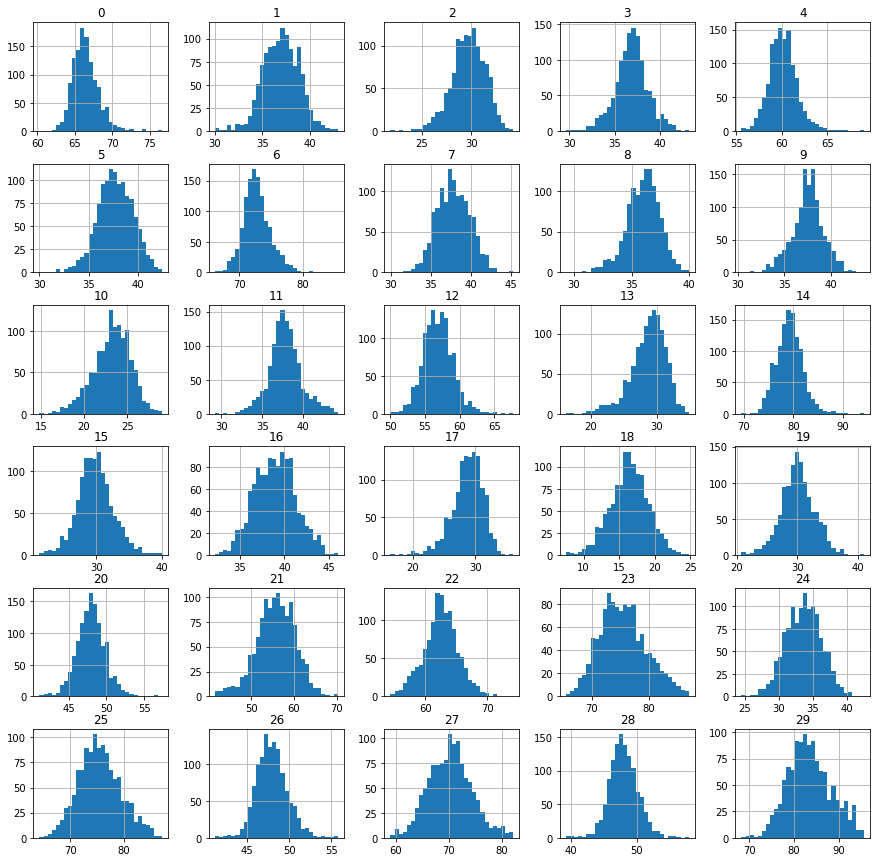

In [48]:
tempdf.hist(bins = 30, figsize=(15,15))

Use the next two cells if you want to explore the dev data to make sure it's clean as well

In [49]:
#tempdf = pd.DataFrame(noNA_dev_labels)

In [50]:
#tempdf.hist(bins = 30, figsize=(15,15))

In [52]:
#Confirm size of the datasets
print(noNA_train_data.shape)
print(noNA_train_labels.shape)
print(noNA_dev_data.shape)
print(noNA_dev_labels.shape)

(1200, 9216)
(1200, 30)
(940, 9216)
(940, 30)


## Modeling on the data
First we will look at the full dataset with NAs

In [55]:
model = Sequential()
# model.add(Dense(30, input_dim=9216, activation='sigmoid'))
# model.add(Dense(30, input_dim=30, activation='sigmoid'))
model.add(Dense(units=30, input_dim=9216, activation='softmax'))

sgd = optimizers.SGD(lr=0.01)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
start_time = time.time()
history = model.fit(train_data, train_labels, shuffle=False, batch_size=1, verbose=0, epochs=10) 
print ('Train time = %.2f' %(time.time() - start_time))
score = model.evaluate(dev_data, dev_labels, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Train time = 43.80
Test score: nan
Test accuracy: 0.007808687165379524


With so many NAs in the data, the model is not able to perform. Now we will do the same model but on the cleaned noNA datasets

In [56]:
model = Sequential()
# model.add(Dense(30, input_dim=9216, activation='sigmoid'))
# model.add(Dense(30, input_dim=30, activation='sigmoid'))
model.add(Dense(units=30, input_dim=9216, activation='softmax'))

sgd = optimizers.SGD(lr=0.01)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
start_time = time.time()
history = model.fit(noNA_train_data, noNA_train_labels, shuffle=False, batch_size=1, verbose=0, epochs=10) 
print ('Train time = %.2f' %(time.time() - start_time))
score = model.evaluate(noNA_dev_data, noNA_dev_labels, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Train time = 11.39
Test score: 10244261888.0
Test accuracy: 0.5255318880081177


In [57]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 30)                276510    
                                                                 
Total params: 276,510
Trainable params: 276,510
Non-trainable params: 0
_________________________________________________________________


## Let's try adding more layers

In [58]:
model2 = Sequential()
model2.add(Dense(30, input_dim=9216, activation='sigmoid'))
# model2.add(Dense(30, input_dim=30, activation='softmax'))
model2.add(Dropout(0.5))
model2.add(Dense(units=30, input_dim=30, activation='softmax'))

sgd = optimizers.SGD(lr=0.0001)
model2.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
start_time = time.time()
history = model2.fit(noNA_train_data, noNA_train_labels, shuffle=False, batch_size=10, verbose=0, epochs=50) 
print ('Train time = %.2f' %(time.time() - start_time))
score2 = model2.evaluate(noNA_dev_data, noNA_dev_labels, verbose=0) 
print('Test score:', score2[0]) 
print('Test accuracy:', score2[1])

Train time = 11.73
Test score: 600638.0625
Test accuracy: 0.5255318880081177


No additional gain on original model. Need to review why this is the case. Any ideas?

In [59]:
model2.summary() 

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 30)                276510    
                                                                 
 dropout_1 (Dropout)         (None, 30)                0         
                                                                 
 dense_11 (Dense)            (None, 30)                930       
                                                                 
Total params: 277,440
Trainable params: 277,440
Non-trainable params: 0
_________________________________________________________________


## Convolutional Model Baseline Attempt

In [61]:
#reshape data into 2D arrays
x_train_96x96 = noNA_train_data.reshape(noNA_train_data.shape[0], 96, 96, 1)
x_dev_96x96 = noNA_dev_data.reshape(noNA_dev_data.shape[0], 96, 96, 1)

model = Sequential() 
model.add(Conv2D(96, kernel_size=(3, 3),activation='relu',input_shape=(96, 96, 1)))
model.add(Conv2D(192, (3, 3), activation='sigmoid'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(units=50, input_dim=384, activation='sigmoid')) 
model.add(Dense(units=30, input_dim=50, activation='softmax')) 

## Cost function & Objective (and solver)
sgd = optimizers.SGD(lr=0.01)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train_96x96, noNA_train_labels, batch_size=100, epochs=5, verbose=1, validation_data=(x_dev_96x96, noNA_dev_labels))
score = model.evaluate(x_dev_96x96, noNA_dev_labels, verbose=0)
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Epoch 1/5
12/12 [==============================] - 38s 3s/step - loss: 57390.1328 - accuracy: 0.6942 - val_loss: 129342.9453 - val_accuracy: 0.5255
Epoch 2/5
12/12 [==============================] - 39s 3s/step - loss: 190228.4219 - accuracy: 0.8458 - val_loss: 263987.4062 - val_accuracy: 0.5255
Epoch 3/5
12/12 [==============================] - 37s 3s/step - loss: 324449.7812 - accuracy: 0.8458 - val_loss: 398631.8438 - val_accuracy: 0.5255
Epoch 4/5
12/12 [==============================] - 38s 3s/step - loss: 458200.6875 - accuracy: 0.8458 - val_loss: 533275.9375 - val_accuracy: 0.5255
Epoch 5/5
12/12 [==============================] - 37s 3s/step - loss: 592549.4375 - accuracy: 0.8458 - val_loss: 667920.3125 - val_accuracy: 0.5255
Test score: 667920.25
Test accuracy: 0.5255318880081177


Again, no improvement in the test accuracy even with additional layers. No changes with batch size, epochs, or learning rate.

In [63]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 96)        960       
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 192)       166080    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 192)      0         
 )                                                               
                                                                 
 dropout_2 (Dropout)         (None, 46, 46, 192)       0         
                                                                 
 flatten (Flatten)           (None, 406272)            0         
                                                                 
 dense_12 (Dense)            (None, 50)                20313650  
                                                     

## Appendix: More EDA

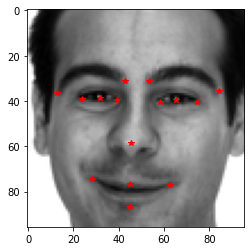

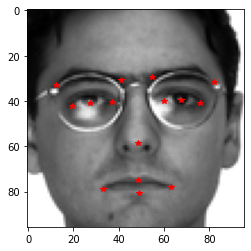

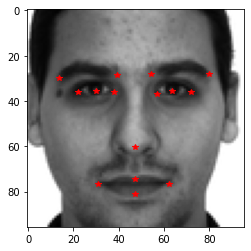

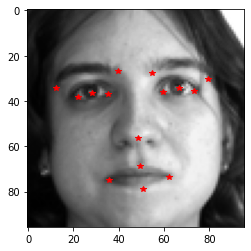

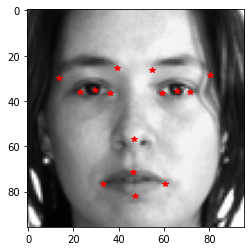

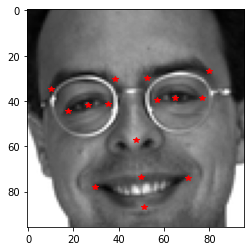

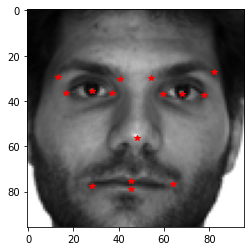

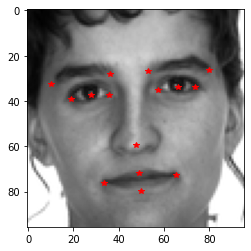

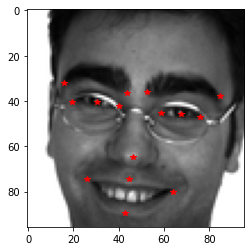

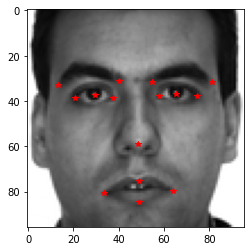

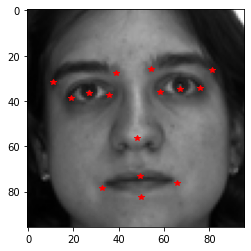

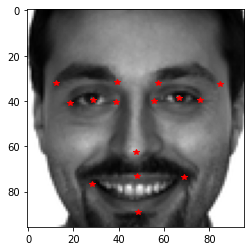

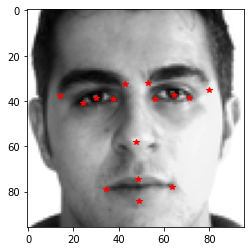

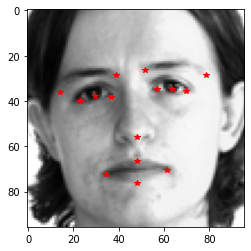

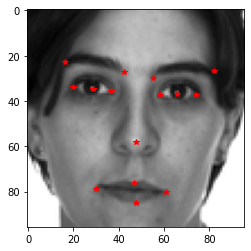

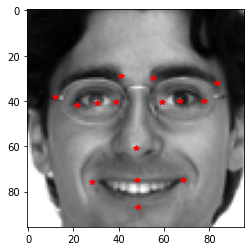

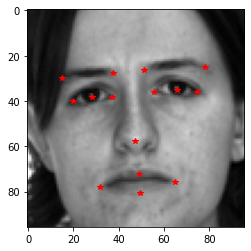

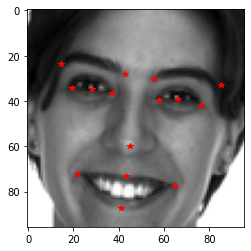

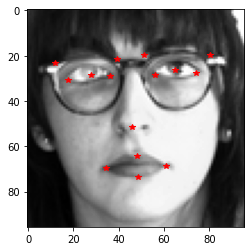

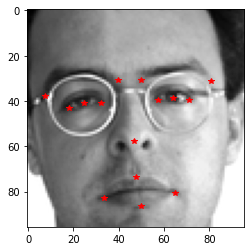

In [64]:
for i in range(20):
    plt.imshow(noNA_dev_data[i].reshape(96,96),cmap='gray')
    #place a point for each of the pictures on the specified coordinates
    for loc in range(0, len(noNA_dev_labels[i]),2):
        plt.plot(noNA_dev_labels[i][loc], noNA_dev_labels[i][loc+1], '*r')
    plt.show()
    